In [1]:
import configparser
import psycopg2
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

config = configparser.ConfigParser()
config.read('dwh.cfg')

['dwh.cfg']

## Step 1: Creating Tables

In [2]:
!python create_tables.py

Tables are created!


## Step 2: Run ETL pipline

In [3]:
%time !python etl.py

Staging tables are loaded!
Data is imported!
table_name total_rows
songplays 6820
time 6813
users 104
artists 10025
songs 14896
There are some duplicates!
[('users_id', 8)]
[('artists_id', 426)]
The ETL process is completed!
CPU times: user 2.96 s, sys: 556 ms, total: 3.51 s
Wall time: 1min 41s


**Through the quality check, we found there are duplicates in users_id and artists_id.** We need to keep that in mind when we do data analysis.

## Step 3: EDA

Now, we will answer some questions to help the client understand their users based on our data.

In [4]:
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values())) 

### 1. Whare are the top 10 locations that have the most users?

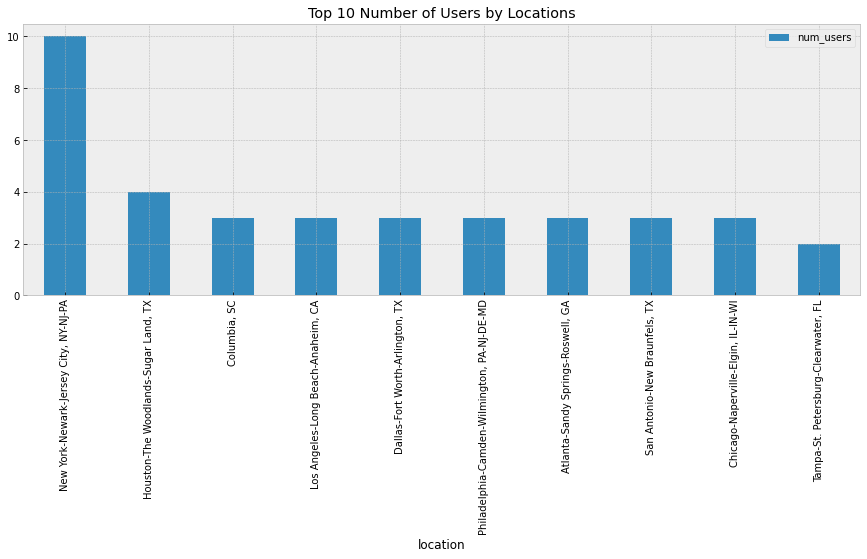

In [5]:
sql = '''
SELECT 
    s.location,
    count(DISTINCT s.user_id) as num_users
FROM songplays s
GROUP BY s.location

'''
df = pd.read_sql(sql, conn) 

df.set_index('location') \
    .sort_values(by = 'num_users', ascending = False) \
    .head(10) \
    .plot(kind = 'bar',
          figsize = (15, 5),
          color=next(color_cycle),
          title = 'Top 10 Number of Users by Locations')
plt.show()

Based on the data given, the New York-Newark-Jersey City has the most active users

### 2. What's the top 5 songs that users played the most?

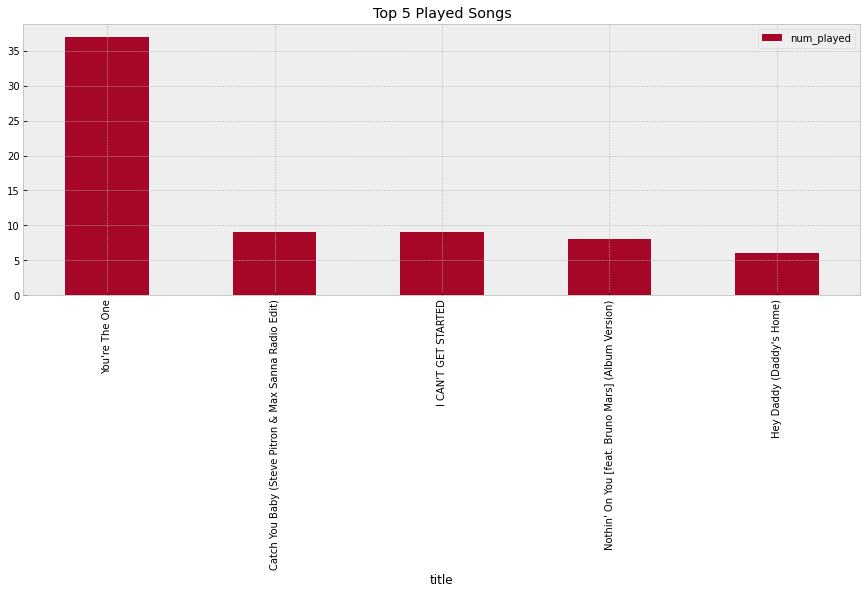

In [6]:
sql = '''
SELECT 
    title,
    count(*) as num_played
FROM songplays s
    LEFT JOIN songs so on s.song_id = so.song_id
    WHERE title IS NOT NULL
GROUP BY title
'''

df = pd.read_sql(sql, conn) 

df.set_index('title') \
    .sort_values(by = 'num_played', ascending = False) \
    .head(5) \
    .plot(kind = 'bar',
          figsize = (15, 5),
          color=next(color_cycle),
          title = 'Top 5 Played Songs')
plt.show()

The song "You're The One" is the most popular song!

### 3. Who is the most productive artist?

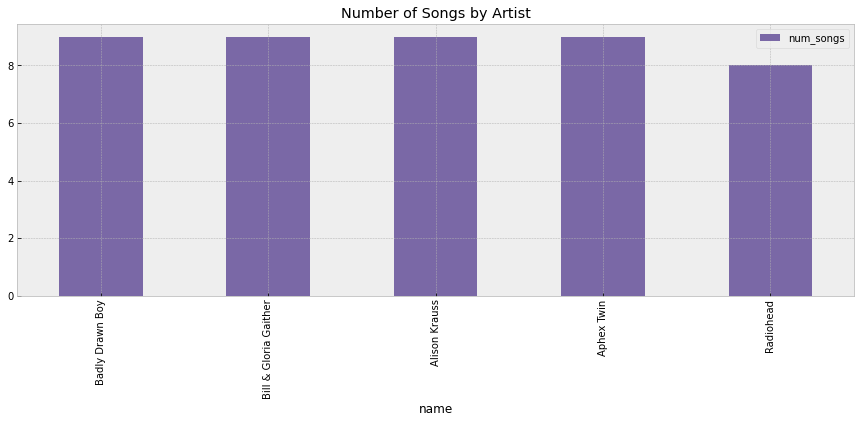

In [7]:
sql = '''
SELECT 
    name,
    count(*) as num_songs
FROM (
        SELECT
            *
        FROM (
                SELECT 
                    ROW_NUMBER() OVER (PARTITION BY artist_id ORDER BY name) as row_num,
                    artist_id,
                    name
                FROM artists
             ) T1 
        WHERE row_num = 1
) T2 LEFT JOIN songs s on s.artist_id = T2.artist_id
GROUP BY name

'''
df = pd.read_sql(sql, conn) 

df.set_index('name') \
    .sort_values(by = 'num_songs', ascending = False) \
    .head(5) \
    .plot(kind = 'bar',
          figsize = (15, 5),
          color=next(color_cycle),
          title = 'Number of Songs by Artist')
plt.show()

There are four artists tied for first, who wrote 9 songs

### 4. When do users like to listen to music(Which hour of the day)?

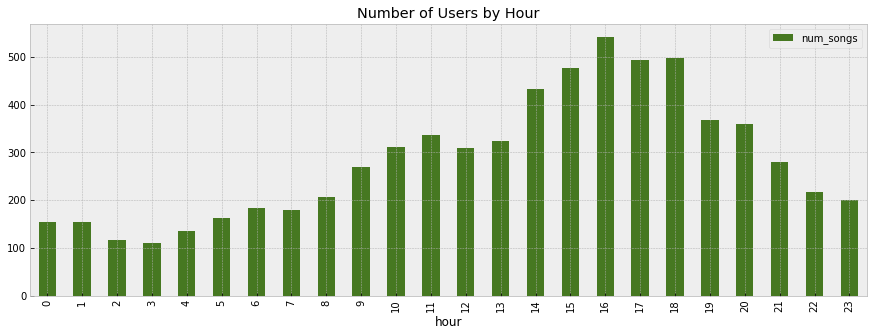

In [8]:
sql = '''
SELECT 
    hour,
    count(*) as num_songs
FROM songplays s
    LEFT JOIN time t on t.start_time = s.start_time
GROUP BY hour

'''
df = pd.read_sql(sql, conn) 

df.sort_values(by = 'hour') \
    .set_index('hour') \
    .plot(kind = 'bar',
          figsize = (15, 5),
          color=next(color_cycle),
          title = 'Number of Users by Hour')
plt.show()

Users are like to listen to music around dinner time

### 5. Are there more male users or femal users?

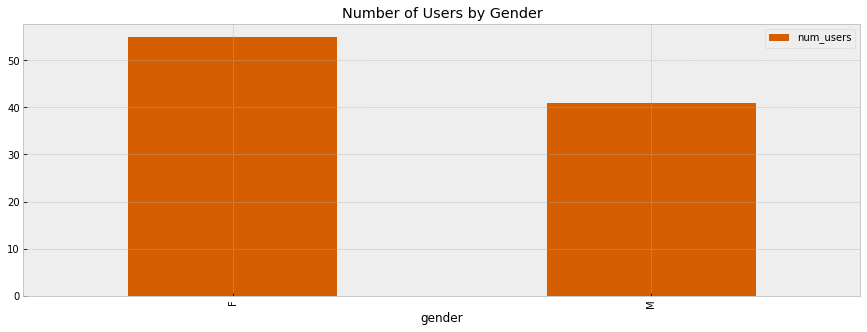

In [9]:
sql = '''
SELECT 
    gender,
    count(DISTINCT user_id) as num_users
FROM users
GROUP BY gender

'''
df = pd.read_sql(sql, conn) 

df.set_index('gender') \
    .plot(kind = 'bar',
          figsize = (15, 5),
          color=next(color_cycle),
          title = 'Number of Users by Gender')
plt.show()

We have more female users than male users.

In [10]:
conn.close()

With the data warehouse, the end users can analyze the data, answer business questions and find out insights to help decision-making easily.